In [1]:
import os
import numpy as np
import pandas as pd

from nilearn import image
from nilearn.image import math_img
from nilearn import plotting
from nilearn.glm import threshold_stats_img
from nilearn.input_data import NiftiMasker
from nilearn.image import load_img
from nilearn.masking import apply_mask

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from statannotations.Annotator import Annotator

/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task01/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# Settings
data_dir = '/DATAPOOL/BRAINPLAYBACK/BIDS-BRAINPLAYBACK-TASK1/'
space_label = "MNI152NLin2009cAsym"
derivatives_folder = "derivatives/fmriprep/fmriprep"
task_label = "01"
out_dir = os.path.join(data_dir,"derivatives","nilearn_glm")
out_dir_group = os.path.join(data_dir,"derivatives","nilearn_glm","group")
sub_labels = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19']

In [3]:
# condition names
condition_names = ['Q1_p','Q2_p','Q3_p','Q4_p']

# create strings for contrasts in the format of "condition_name - Noise"
contrasts = []

# add contrast all conditions vs. noise
contrasts.append("Q1_p + Q2_p + Q3_p + Q4_p - Noise*4")

# iterate to add the other contrasts
for condition in condition_names:
    contrasts.append(condition + " - Noise")

# add more contrasts based on the arousal and valence
contrasts.append("Q1_p*0.5 + Q2_p*0.5 - Q3_p*0.5 - Q4_p*0.5") # positive arousal vs. negative arousal
contrasts.append("Q1_p*0.5 + Q4_p*0.5 - Q3_p*0.5 - Q2_p*0.5") # positive valence vs. negative valence

# just for fun - each Q against the other
contrasts.append("Q1_p - Q2_p")
contrasts.append("Q1_p - Q3_p")
contrasts.append("Q1_p - Q4_p")
contrasts.append("Q2_p - Q3_p")
contrasts.append("Q2_p - Q4_p")
contrasts.append("Q3_p - Q4_p")

contrasts_renamed = ['Q1234MinusNoise',
                     'Q1MinusNoise',
                     'Q2MinusNoise',
                     'Q3MinusNoise',
                     'Q4MinusNoise',
                     'PositiveArousalMinusNegativeArousal',
                     'PositiveValenceMinusNegativeValence',
                     'Q1MinusQ2',
                     'Q1MinusQ3',
                     'Q1MinusQ4',
                     'Q2MinusQ3',
                     'Q2MinusQ4',
                     'Q3MinusQ4']

contrastList = contrasts_renamed[1:5]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]


/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task01/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task01/lib/python3.9/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(



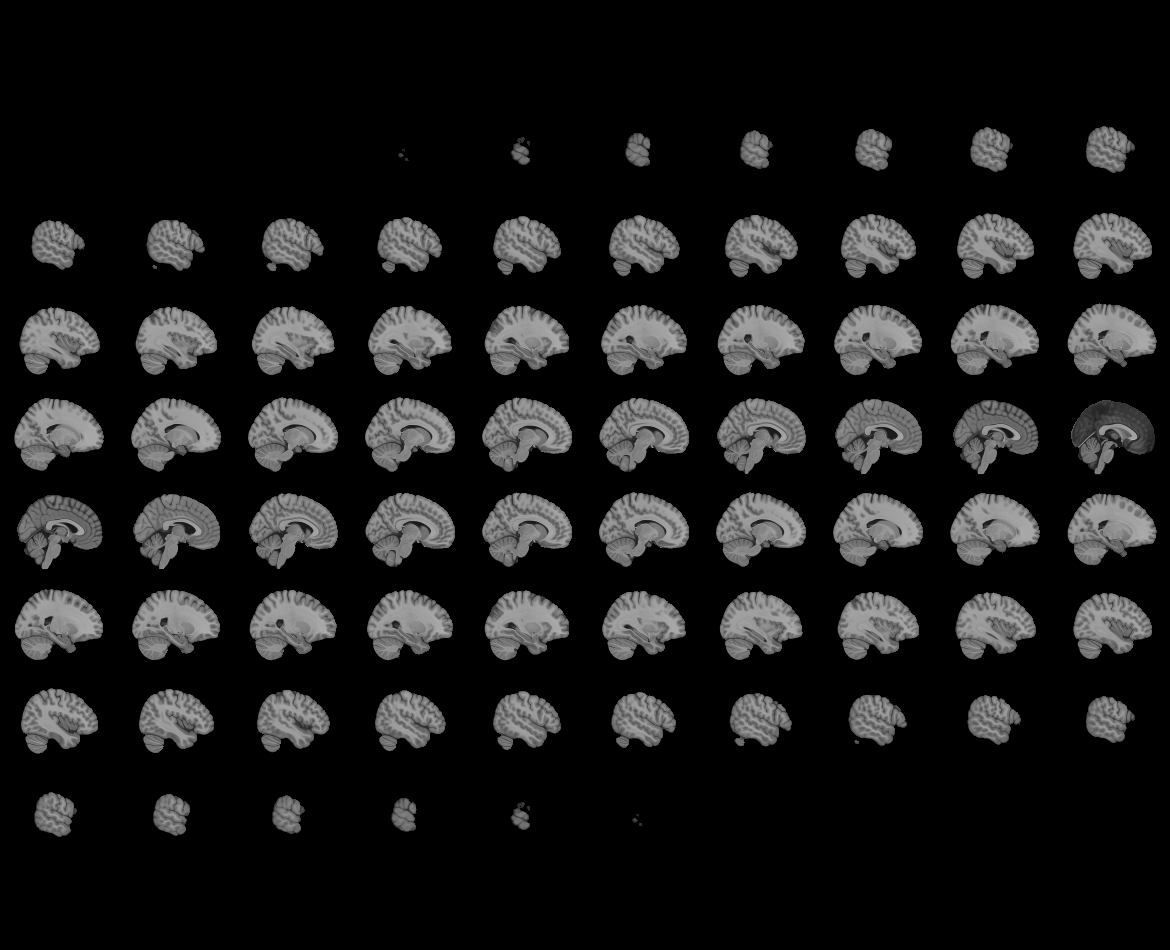
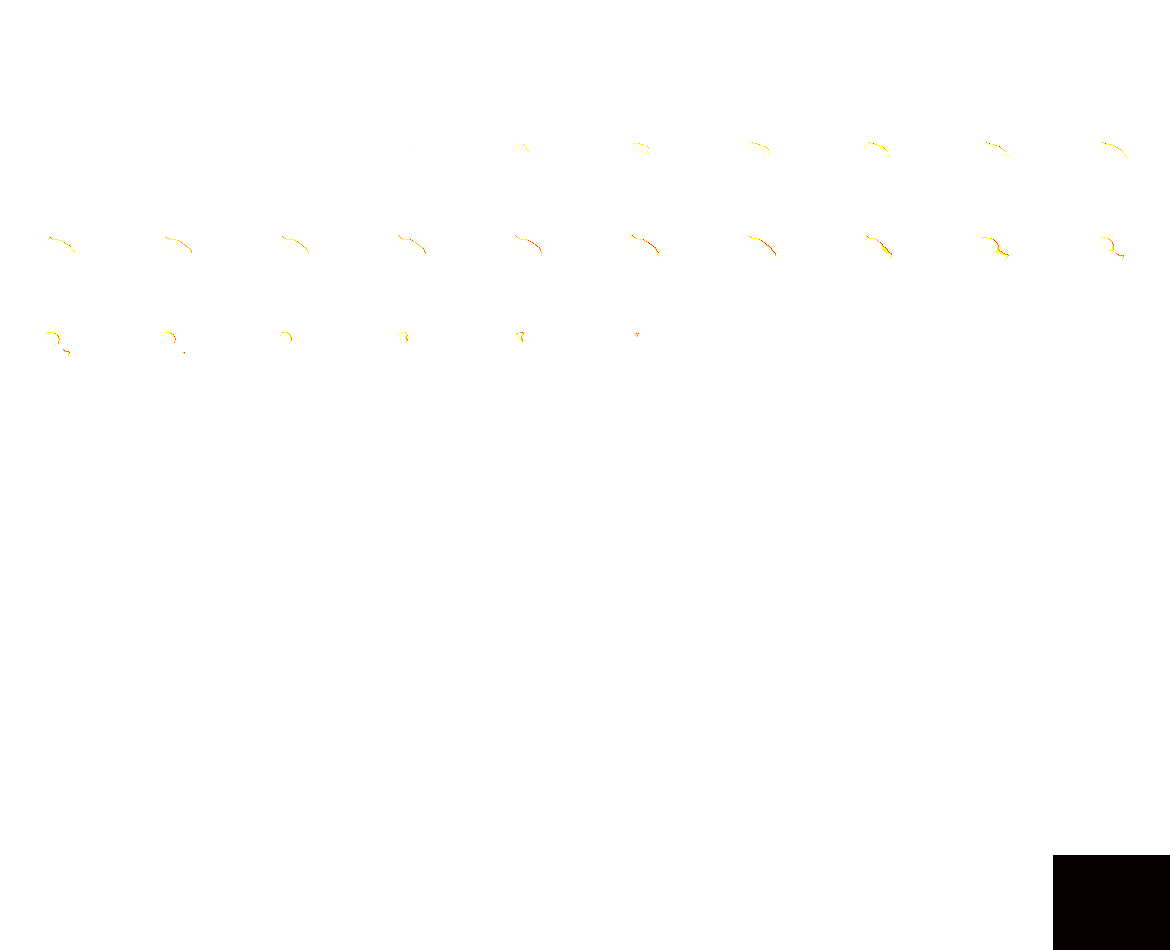

In [4]:
# Load cluster map
image_path = os.path.join(out_dir_group,
             f"group_task-{task_label}_clustermap_con-Q1234MinusNoise_c-fdr_p-0.005_clusterk-25.nii.gz")


cluster_map = image.load_img(image_path)

# plot cluster_map
#plotting.view_img(cluster_map, vmin=0, vmax=17, symmetric_cmap=False, cmap='Dark2')

# find unique values in cluster_map_g[0]
cluster_list = np.unique(cluster_map.get_fdata())

# remove zero (this is all of the clusters)
cluster_list = cluster_list[1:]

print(cluster_list)

# check first cluster
mask1 = math_img(f'img == {cluster_list[1]}', img=cluster_map)

plotting.view_img(mask1, vmax=1, vmin=0, symmetric_cmap=False, cmap='hot')


In [5]:
# Thresholds
hc = 'fdr' # None, 'bonferroni', 'fdr'
ct = 10 # cluster threshold
alpha = 0.05 # p-value threshold

In [7]:
# binarize the cluster map and export as nifti
#mask1 = math_img(f'img > 0', img=cluster_map)
#plotting.view_img(mask1, vmin=0, symmetric_cmap=False, cmap='hot')
##save mask1
#mask1.to_filename(f"group_task-{task_label}_clustermask_con-Q1234MinusNoise_c-fdr_p-0.005_clusterk-25.nii.gz")

In [8]:
# extract z values and betas from clusters (this takes 20 minutes)

# create a data frame of the z values for each ROI and each contrast
df = pd.DataFrame(columns=['subject', 'cluster', 'contrast', 'z_value', 'beta'])

for rr in range(len(cluster_list)):

    print(f"Extracting cluster {cluster_list[rr]}")

    cluster_mask = math_img(f'img == {cluster_list[rr]}', img=cluster_map)

    for subject in sub_labels:

        # intersect cluster map with subject-level z map (all Quadrants vs. Noise)
        z_map_allQ_path = os.path.join(out_dir, f"sub-{subject}_task-{task_label}_stat-z_con-Q1234MinusNoise.nii.gz")

        clean_map, thres = threshold_stats_img(
            z_map_allQ_path, alpha=alpha, height_control=hc, cluster_threshold=ct
        )

        clean_map_mask = math_img('img > 0', img=clean_map)
        
        # intersect
        intersect_mask = math_img('img1 * img2', img1=clean_map_mask, img2=cluster_mask)

        # check if intersect_mask is empty
        if np.sum(intersect_mask.get_fdata()) == 0:
            print(f"Cluster {cluster_list[rr]} intersect mask is empty for subject {subject}")
            for cc in range(len(contrastList)):
                df.loc[len(df)] = [subject, cluster_list[rr], contrastList[cc], None, None]
            continue

        for cc in range(len(contrastList)): # iterate on the quadrants

            z_map_path = os.path.join(out_dir, f"sub-{subject}_task-{task_label}_stat-z_con-{contrastList[cc]}.nii.gz")
            beta_map_path = os.path.join(out_dir, f"sub-{subject}_task-{task_label}_stat-beta_con-{contrastList[cc]}.nii.gz")
            
            z_val = np.mean(apply_mask(z_map_path, intersect_mask))
            beta_val = np.mean(apply_mask(beta_map_path, intersect_mask))

            df.loc[len(df)] = [subject, cluster_list[rr], contrastList[cc], z_val, beta_val]   


Extracting cluster 1.0


KeyboardInterrupt: 

In [30]:
df

,subject,cluster,contrast,z_value,beta
0,01,1.0,Q1MinusNoise,6.991687,1.010595
1,01,1.0,Q2MinusNoise,6.956887,0.94236
2,01,1.0,Q3MinusNoise,5.215042,0.75219
3,01,1.0,Q4MinusNoise,7.408613,0.8592
4,02,1.0,Q1MinusNoise,8.30437,1.069635
...,...,...,...,...,...
1287,18,17.0,Q4MinusNoise,1.678124,0.06704
1288,19,17.0,Q1MinusNoise,2.640375,0.598402
1289,19,17.0,Q2MinusNoise,2.860861,0.753658
1290,19,17.0,Q3MinusNoise,4.1667,1.159146


In [31]:
# save df as tsv
df.to_csv(os.path.join(out_dir_group, f"group_task-{task_label}_clustermap-intersect-values_c-fdr_p-0.005_clusterk-25.tsv"), sep='\t', index=False)

In [6]:
# Load tsv as dataframe
df = pd.read_csv(os.path.join(out_dir_group, f"group_task-{task_label}_clustermap-intersect-values_c-fdr_p-0.005_clusterk-25.tsv"), sep='\t')

In [7]:
df[df['cluster']==cluster_list[0]]

,subject,cluster,contrast,z_value,beta
0,1,1.0,Q1MinusNoise,6.991687,1.010595
1,1,1.0,Q2MinusNoise,6.956887,0.942360
2,1,1.0,Q3MinusNoise,5.215042,0.752190
3,1,1.0,Q4MinusNoise,7.408613,0.859200
4,2,1.0,Q1MinusNoise,8.304370,1.069635
...,...,...,...,...,...
71,18,1.0,Q4MinusNoise,10.366685,1.054817
72,19,1.0,Q1MinusNoise,6.725705,1.004572
73,19,1.0,Q2MinusNoise,4.496927,0.809598
74,19,1.0,Q3MinusNoise,6.640205,1.236593


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1MinusNoise vs. Q2MinusNoise: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.658e-04 U_stat=3.100e+02
Q3MinusNoise vs. Q4MinusNoise: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.601e-03 U_stat=9.000e+01
Q1MinusNoise vs. Q3MinusNoise: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.604e-05 U_stat=3.190e+02
Q2MinusNoise vs. Q4MinusNoise: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.458e-02 U_stat=1.030e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1MinusNoise vs. Q2MinusNoise: Mann-Whitney-Wilcoxon test two-sided 

(0.0, 1.0, 0.0, 1.0)

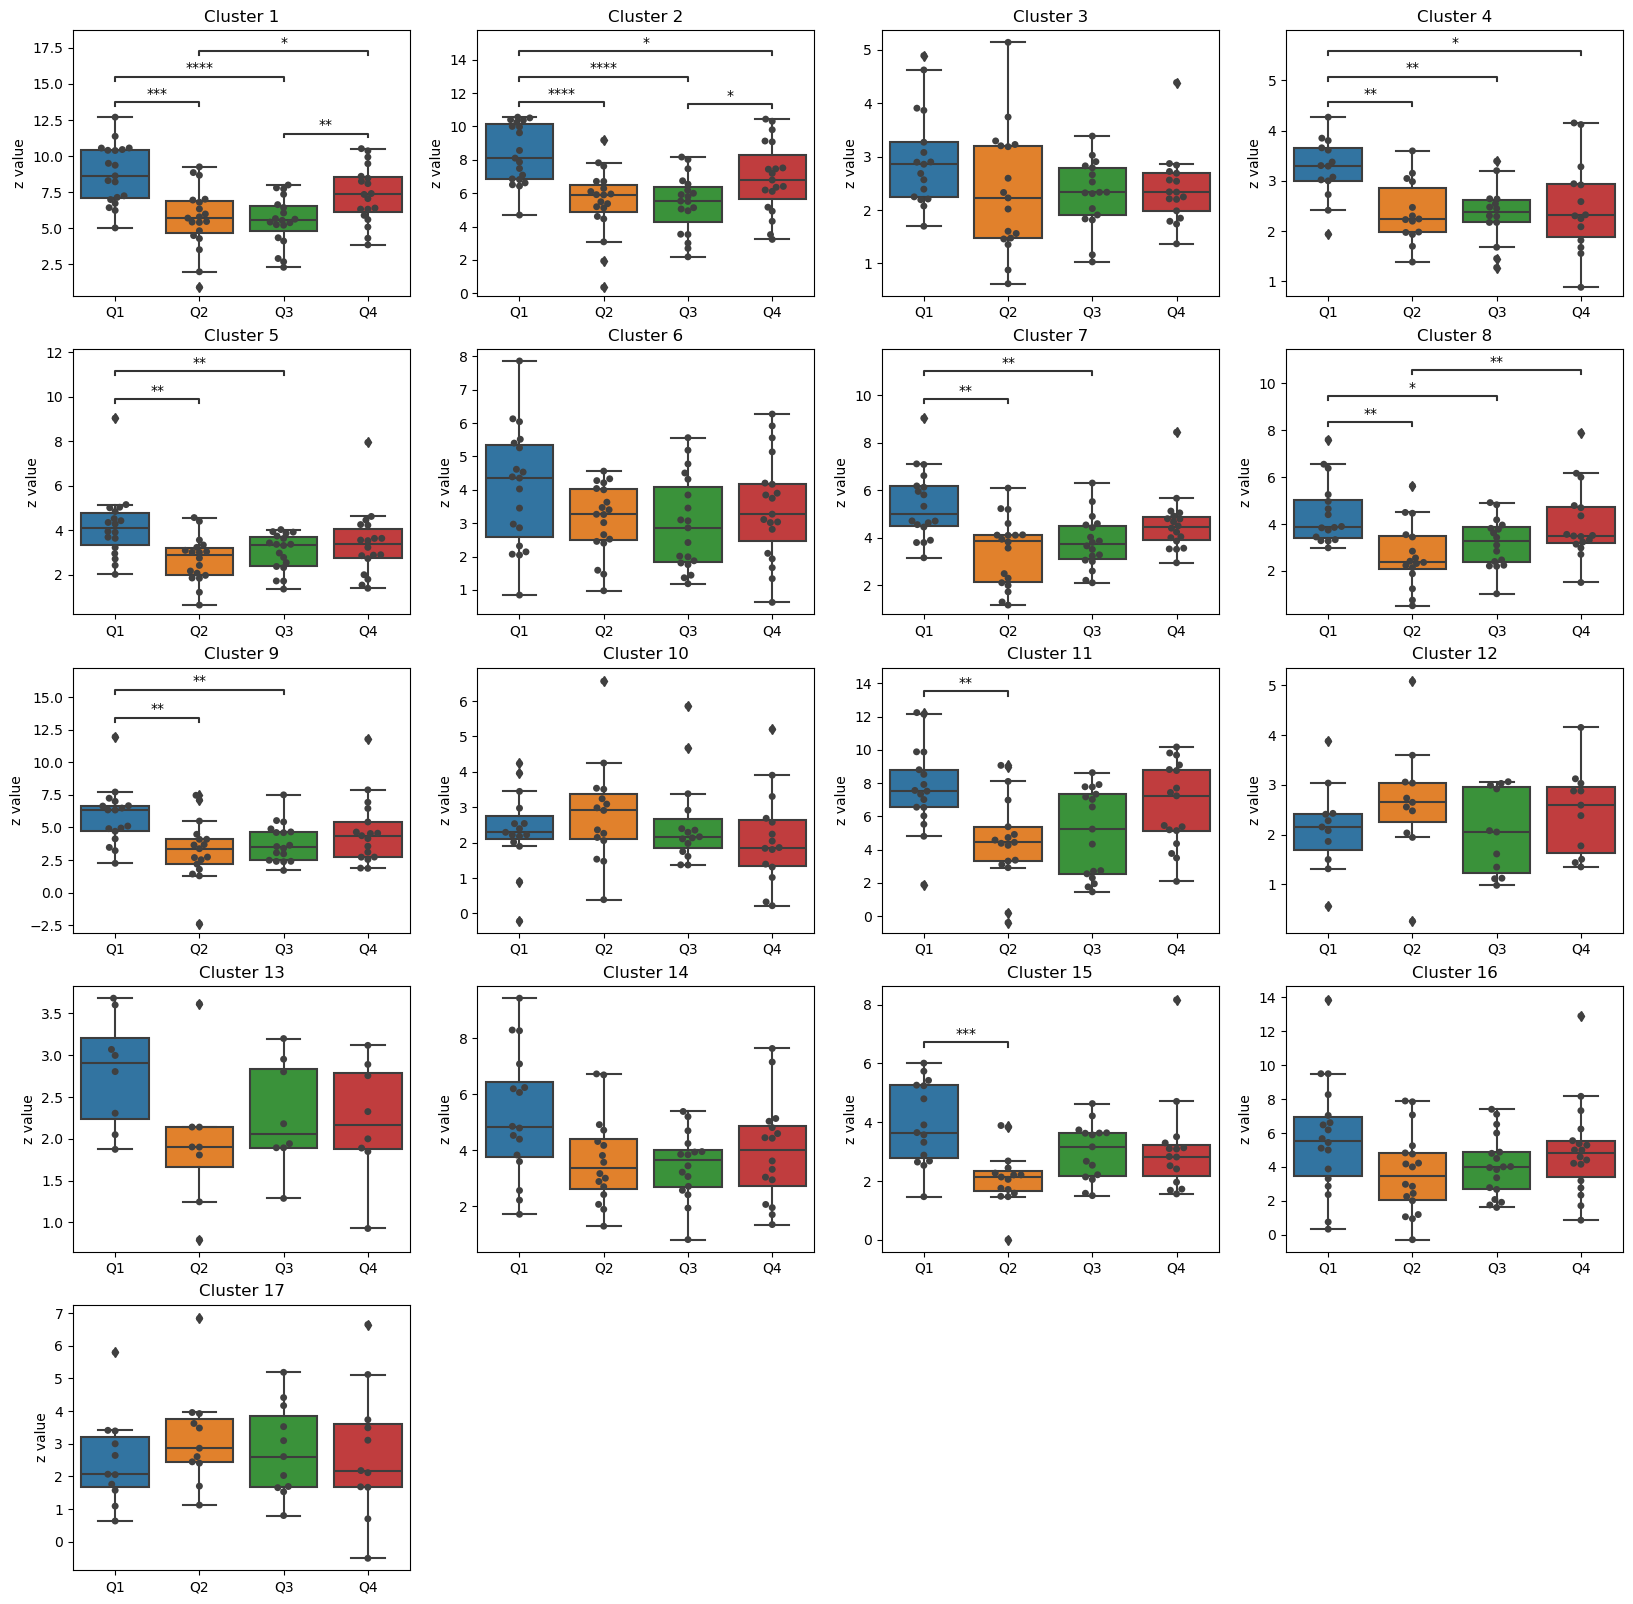

In [8]:
# create a box plot of the z values for the first cluster with the different contrasts and statistical comparison between contrasts
quad_list = ['Q1','Q2','Q3','Q4']
quad_pairs = list(combinations(contrastList, r=2))

# set up the figure
fig, ax = plt.subplots(5,4,figsize=(20, 20))

for rr in range(len(cluster_list)):
    # calculate subplot row and column indices
    row = rr // 4
    col = rr % 4

    # set up the boxplot
    sns.boxplot(x="contrast", y="z_value", data=df[df['cluster']==cluster_list[rr]], ax=ax[row, col])

    # add swarmplot
    sns.swarmplot(x="contrast", y="z_value", data=df[df['cluster']==cluster_list[rr]], color=".25", ax=ax[row, col])

    # add title
    ax[row, col].set_title(f"Cluster {int(cluster_list[rr])}")
    ax[row, col].set_xticklabels(quad_list)
    ax[row, col].set_xlabel('')
    ax[row, col].set_ylabel('z value')

    # statistical comparisons between contrasts
    annotator = Annotator(ax[row, col], quad_pairs, data=df[df['cluster']==cluster_list[rr]], x='contrast', y='z_value', order=contrastList)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=1, comparisons_correction='fdr_bh', hide_non_significant=True)
    annotator.apply_and_annotate()

# clear the last three subplots
ax[4,1].axis('off')
ax[4,2].axis('off')
ax[4,3].axis('off')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1MinusNoise vs. Q3MinusNoise: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.076e-03 U_stat=2.930e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1MinusNoise vs. Q2MinusNoise: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.205e-02 U_stat=2.670e+02
Q1MinusNoise vs. Q3MinusNoise: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.360e-04 U_stat=2.980e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annot

(0.0, 1.0, 0.0, 1.0)

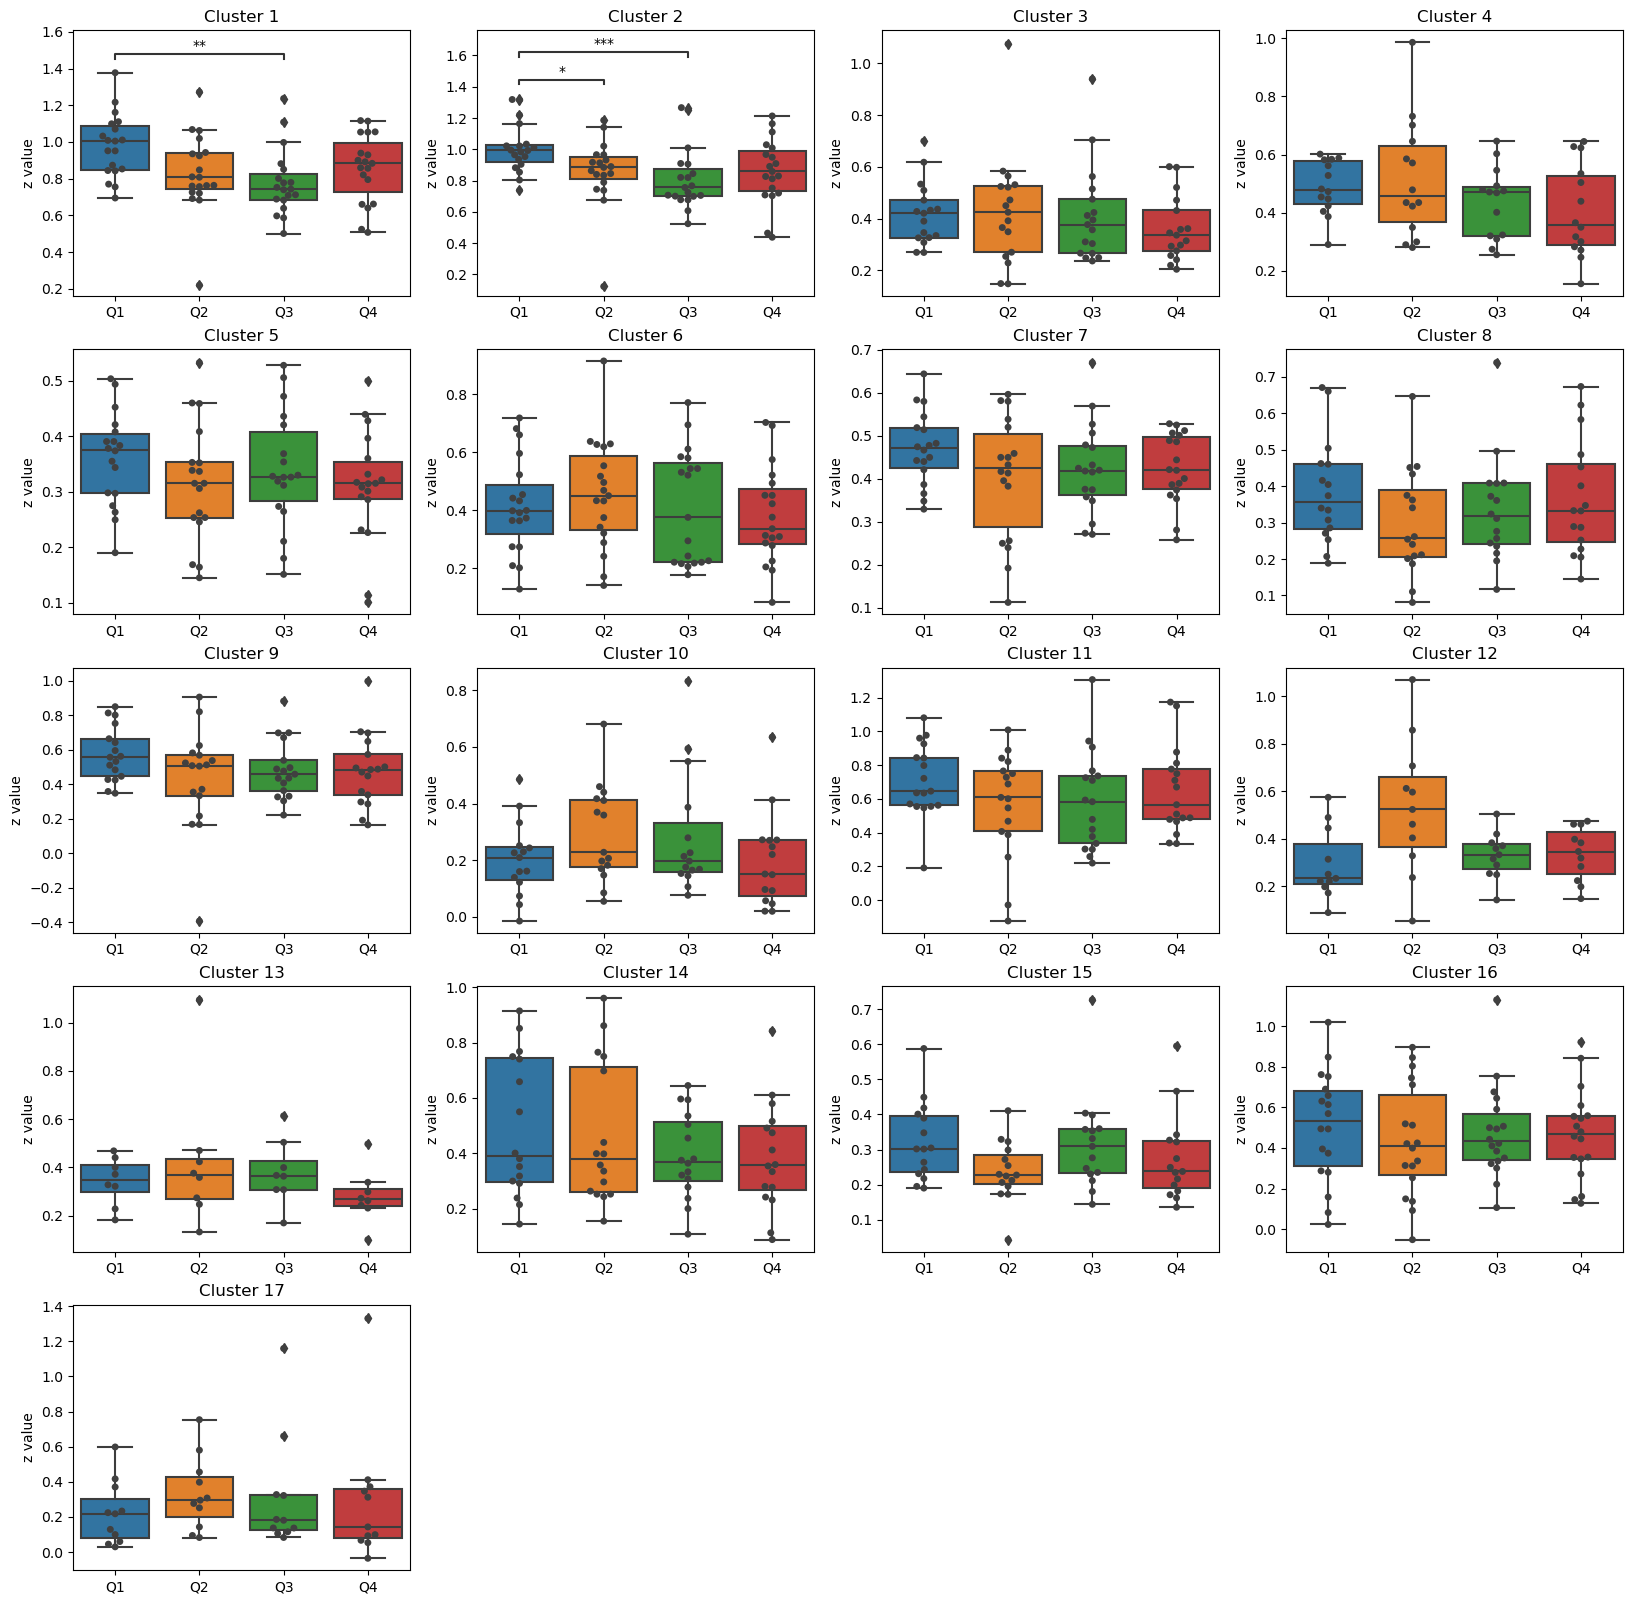

In [11]:
# create a box plot of the beta values for the first cluster with the different contrasts and statistical comparison between contrasts
quad_list = ['Q1','Q2','Q3','Q4']
quad_pairs = list(combinations(contrastList, r=2))

# set up the figure
fig, ax = plt.subplots(5,4,figsize=(20, 20))

for rr in range(len(cluster_list)):
    # calculate subplot row and column indices
    row = rr // 4
    col = rr % 4

    # set up the boxplot
    sns.boxplot(x="contrast", y="beta", data=df[df['cluster']==cluster_list[rr]], ax=ax[row, col])

    # add swarmplot
    sns.swarmplot(x="contrast", y="beta", data=df[df['cluster']==cluster_list[rr]], color=".25", ax=ax[row, col])

    # add title
    ax[row, col].set_title(f"Cluster {int(cluster_list[rr])}")
    ax[row, col].set_xticklabels(quad_list)
    ax[row, col].set_xlabel('')
    ax[row, col].set_ylabel('z value')

    # statistical comparisons between contrasts
    annotator = Annotator(ax[row, col], quad_pairs, data=df[df['cluster']==cluster_list[rr]], x='contrast', y='beta', order=contrastList)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=1, comparisons_correction='fdr_bh', hide_non_significant=True)
    annotator.apply_and_annotate()

# clear the last three subplots
ax[4,1].axis('off')
ax[4,2].axis('off')
ax[4,3].axis('off')